# Fernando Leon Franco

In [172]:
import matplotlib.pyplot as plt
import nltk
import numpy as np

In [173]:
def get_texts_from_file(path_corpus, path_truth):

    tr_txt = [] # Aqui van los twits
    tr_y = [] # Aqui van las etiquetas

    with open(path_corpus, 'r', encoding='utf-8') as f_corpus, open(path_truth , 'r', encoding='utf-8') as f_truth:
        
        for twitt in f_corpus:
            tr_txt += [twitt]
            
        for label in f_truth:
            tr_y += [label]
    
    return tr_txt,tr_y        

In [174]:
path_global = "/Users/ferleon/Github/semestre_v/procesamiento_lenguaje"
path_corpus = path_global + '/mex20_train.txt'
path_truth = path_global + '/mex20_train_labels.txt'


tr_txt, tr_y = get_texts_from_file(path_corpus,path_truth)



# Construir los datos de validación
path_corpus = path_global + '/mex20_val.txt'
path_truth = path_global + '/mex20_val_labels.txt'


va_txt, va_y = get_texts_from_file(path_corpus,path_truth)


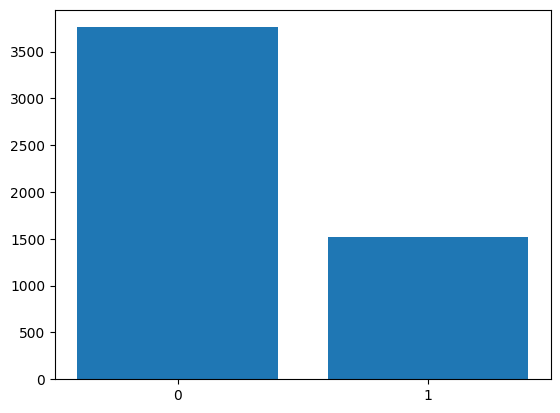

0: 3759
1: 1519


In [175]:
# Ver los datos saber si es balanceado o desbalanceado
count_0 = 0
count_1 = 0

for label in tr_y:
    label = label.strip()
    if label == '0':
        count_0 += 1
    elif label == '1':
        count_1 += 1

plt.bar(['0','1'],[count_0,count_1])
plt.show()

print(f"0: {count_0}")
print(f"1: {count_1}")

In [176]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

corpus_de_palabras = []

for doc in tr_txt:
    corpus_de_palabras += tokenizer.tokenize(doc)
    
fdist = nltk.FreqDist(corpus_de_palabras)



In [177]:
"""
VERSION DEL PROFE
"""


def sort_dist(freq_dist):
    aux = [(freq_dist[key], key) for key in freq_dist.keys()]
    aux.sort(reverse=True)
    return aux

vocabulario = sort_dist(fdist)

vocabulario = vocabulario[:5000] # Shape (5000, 2)


# Es redundante pero asegura un orden en diccionario en Python (No importa por que python se indexa)

dict_indices = {}

contador = 0

for peso, palabra in vocabulario:
    dict_indices[palabra] = contador
    contador += 1
    

def built_bow_tr_profe_version(tuits, Vocabulario, dict_indices):
    
    BOW = np.zeros((len(tuits), len(Vocabulario)), dtype=int)

    contador = 0
    for tr in tuits:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr.lower())) # Tuit Tokenizado
        for palabra in fdist_doc:
            if palabra in dict_indices:
                BOW[contador, dict_indices[palabra]] = fdist_doc[palabra] # FRECUENCIA DE LA PALABRA EN VEZ DE HACERLO BINARIO
        contador += 1

    return BOW


In [178]:
bolsa_de_palabras_tr = built_bow_tr_profe_version(tr_txt, vocabulario, dict_indices)
print(bolsa_de_palabras_tr.shape)

(5278, 5000)


In [179]:
bolsa_de_palabras_tr

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], shape=(5278, 5000))

# Compute Document Ocurrence Representation


In [180]:


# count * log(T / Nk)
def calcular_peso(freq, Nk_j, T):
    if freq == 0:
        return 0.0
    return freq * np.log(T / max(1, Nk_j)) 



def compute_dor(bow, vocabulario):
    renglones, columnas = bow.shape
    assert columnas == len(vocabulario), "El vocabulario no coincide con columnas en BOW"
    

    Nk = (bow > 0).sum(axis=0) # Tamaño 
    T = renglones

    dor = np.zeros((renglones, columnas), dtype=float)
    
    for i in range(renglones):
        for j in range(columnas):
            dor[i, j] = calcular_peso(bow[i, j], Nk[j], T)
            
    return dor

In [181]:
dor = compute_dor(bolsa_de_palabras_tr, vocabulario)
print(dor.shape)

(5278, 5000)


In [182]:
dor

array([[0.        , 1.61486246, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.84894225, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92447113, 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(5278, 5000))

In [190]:
def compute_dor_profe(TR):
    DTR = np.zeros((TR.shape[0], TR.shape[1]), dtype=float)

    tam_v = TR.shape[1] # Tamaño del vocabulario TOTAL
    
    for i,doc in enumerate(TR):
        non_zero_positions = np.nonzero(doc)[0] # Esto me dice las dimensiones que no son cero
        tamaño_vocabulario = len(non_zero_positions)
        for termino in non_zero_positions:
            DTR[i, termino] = doc[termino] * np.log(tam_v / tamaño_vocabulario)
    return DTR

In [191]:
DTR = compute_dor_profe(bolsa_de_palabras_tr)

DTR

array([[ 0.        , 10.94534151,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  6.2146081 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  6.57128304,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [11.61828598,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.95224383,  5.95224383,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(5278, 5000))